# Imports

Import python libraries as well as the self written FERMI library.

In [1]:
import sys, os
from os.path import join, split
from getpass import getuser
from glob import glob
from time import strftime
from importlib import reload
from copy import deepcopy
from tqdm.auto import tqdm

# data
import numpy as np
import xarray as xr
import pandas as pd
import h5py

# Images
import imageio
from imageio import imread

# Plotting
import matplotlib.pyplot as plt
from matplotlib.image import NonUniformImage
import matplotlib.gridspec as gridspec
from matplotlib.path import Path

#pyFAI
import pyFAI
pyFAI.disable_opencl=True # get rid of annoying warning ;)
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from pyFAI.detectors import Detector

# Scipy
from scipy.ndimage.filters import median_filter 

# Self-written libraries
sys.path.append(
    f"C:/Users/klose/MBI - Klose/Projects/FERMI_22_05/Code/Post-Beamtime Analysis/library"
)
import process_FERMI_2022 as pf
import interactive
from interactive import cimshow

In [2]:
# interactive plotting
import ipywidgets
%matplotlib widget
plt.rcParams["figure.constrained_layout.use"] = True

# Auto formatting of cells
%load_ext jupyter_black

## Functions

In [3]:
def create_folder(folder):
    """
    Creates input folder if it does not exist yet
    """

    if not (os.path.exists(folder)):
        print("Creating folder " + folder)
        os.makedirs(folder)
    return folder

In [5]:
def preprocess_exp_OF(datafolder, keys=None, sort=False):
    # Loading experiment data
    extension = "_OF"
    exp = pf.get_exp_dataframe(datafolder + extension, keys=keys)
    for k in ["xgm_UH", "xgm_SH", "diode_sum"]:
        exp[k + "_sum"] = exp[k].apply(np.sum)

    exp["diode_sum_mean"] = exp.diode_sum.apply(np.mean)
    exp["diode_sum_std"] = exp.diode_sum.apply(np.std)
    exp["IR_mean"] = exp.IR.apply(np.mean)
    exp["IR_std"] = exp.IR.apply(np.std)
    exp["magnet_mean"] = exp.magnet.apply(np.mean)
    exp["magnet_mean"] = exp.magnet_mean.apply(np.round, args=(3,))
    exp["bunchid"] = exp.bunches.apply(lambda l: l[-1])

    if sort is True:
        exp = exp.sort_values(scan_axis)

    # Loading image data
    exp["images"] = [
        pf.loadh5(fname, extra_keys=["alignz", "PAM/FQPDSum"])[0]
        for fname in exp["filename"]
    ]

    return exp


def preprocess_exp_BG(datafolder, keys=None):
    # Loading background exp dataframe
    extension = "_BG"
    exp_bg = pf.get_exp_dataframe(datafolder + extension, keys=keys)
    exp_bg["bunchid"] = exp.bunches.apply(lambda l: l[-1])
    exp_bg = exp_bg.sort_values("time")

    # Loading background data
    exp_bg["images"] = [
        pf.loadh5(fname, extra_keys=["alignz", "PAM/FQPDSum"])[0]
        for fname in exp_bg["filename"]
    ]

    return exp_bg

In [6]:
# Draw circle mask
def circle_mask(shape, center, radius, sigma="none"):
    """
    Draws circle mask with option to apply gaussian filter for smoothing

    Parameter
    =========
    shape : int tuple
        shape/dimension of output array
    center : int tuple
        center coordinates (ycenter,xcenter)
    radius : scalar
        radius of mask in px. Care: diameter is always (2*radius+1) px
    sigma : scalar
        std of gaussian filter

    Output
    ======
    mask: array
        binary mask, or smoothed binary mask
    ======
    author: ck 2022
    """

    # setup array
    x = np.linspace(0, shape[1] - 1, shape[1])
    y = np.linspace(0, shape[0] - 1, shape[0])
    X, Y = np.meshgrid(x, y)

    # define circle
    mask = np.sqrt(((X - center[1]) ** 2 + (Y - center[0]) ** 2)) <= (radius)
    mask = mask.astype(float)

    # smooth aperture
    if sigma != "none":
        mask = scipy.ndimage.filters.gaussian_filter(mask, sigma)

    return mask


def create_single_polygon_mask(shape, coordinates):
    """
    Creates a polygon mask from coordinates of corner points

    Parameter
    =========
    shape : int tuple
        shape/dimension of output array
    coordinates: nested list
        coordinates of polygon corner points [[yc_1,xc_1],[yc_2,xc_2],...]


    Output
    ======
    mask: array
        binary mask where filled polygon is "1"
    ======
    author: ck 2023
    """

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
    x, y = x.flatten(), y.flatten()

    points = np.vstack((x, y)).T

    path = Path(coordinates)
    mask = path.contains_points(points)
    mask = mask.reshape(shape)
    return mask


def create_polygon_mask(shape, coordinates):
    """
    Creates multiple polygon masks from set of coordinates of corner points

    Parameter
    =========
    shape : int tuple
        shape/dimension of output array
    coordinates: nested list
        coordinates of polygon corner points for multiple polygons
        [[[yc_1,xc_1],[yc_2,xc_2],...],[[yc_1,xc_1],[yc_2,xc_2],...]]

    Output
    ======
    mask: array
        binary mask where filled polygons are "1"
    ======
    author: ck 2023
    """

    if len(coordinates) == 1:
        mask = create_single_polygon_mask(shape, coordinates[0])
    elif len(coordinates) > 1:
        mask = np.zeros(shape)
        for coord in coordinates:
            mask = mask + create_single_polygon_mask(shape, coord)
            mask[mask > 1] = 1

    return mask


def load_poly_masks(polygon_name_list, shape):
    """
    Loads set of polygon masks based on stored coordinates

    Parameter
    =========
    polygon_name_list : list
        shape/dimension of output array


    Output
    ======
    mask: array
        binary mask where filled polygons are "1"
    ======
    author: ck 2023
    """

    mask = []
    for polygon_name in polygon_name_list:
        coord = load_poly_coordinates(polygon_name)
        mask.append(create_polygon_mask(shape, [coord]).astype(float))

    mask = np.array(mask)
    mask = np.sum(mask, axis=0)
    mask[mask > 1] = 1

    return mask

# Experimental details

In [7]:
# Define basic folders
BASEFOLDER = r"C:\Users\klose\MBI - Klose\Projects\FERMI_22_05"
basefolder = join(BASEFOLDER, "Data", "FERMI_22_05")
USER = getuser()

In [8]:
# Dict with most basic experimental parameter
experimental_setup = {
    "ccd_dist": 0.103,  # ccd to sample distance
    "px_size": 11e-6,  # pixel_size of camera
    "binning": 1,  # Camera binning
}

# Setup for azimuthal integrator
detector = Detector(
    experimental_setup["binning"] * experimental_setup["px_size"],
    experimental_setup["binning"] * experimental_setup["px_size"],
)

# General saving folder
folder_general = create_folder(join(BASEFOLDER, "Analysis", "Post-Beamtime-Analysis"))
print("Output Folder: %s" % folder_general)

Output Folder: C:\Users\klose\MBI - Klose\Projects\FERMI_22_05\Analysis\Post-Beamtime-Analysis


# Load Data

## Define Scan ids for loading

In [23]:
# Define scans for loading
sample = "S2205ref"
membrane = "H2"
scan_id = np.arange(33, 40)

scans = [f"%s_HystScan_Inverted_%03d" % (membrane, idx) for idx in scan_id]
scans.pop(2)
print("Loading folders:%s" % scans)

Loading folders:['H2_HystScan_Inverted_033', 'H2_HystScan_Inverted_034', 'H2_HystScan_Inverted_036', 'H2_HystScan_Inverted_037', 'H2_HystScan_Inverted_038', 'H2_HystScan_Inverted_039']


In [47]:
# Xarray keys
xr_keys = ["diode_sum_mean", "diode_sum_std", "IR_mean", "IR_std", "magnet_mean"]

# Extra keys for loading
extra_keys = {
    "diode_sum": "PAM/FQPDSum",
    "IR": "Laser/Energy1",
    "magnet": "DPI/CoilCurrent",
    "bunches": "bunches",
    "time": "",
}

# Create savefolder
fsave = create_folder(
    join(folder_general, sample, membrane, "ID_%03d-%03d" % (scan_id[0], scan_id[-1]))
)

# Setup xarray
data = []

# Loop over all scans
for scan in tqdm(scans):
    # Folder for loading
    datafolder = join(basefolder, sample, scan)

    # Loading experiment and background data
    exp = preprocess_exp_OF(datafolder, keys=extra_keys, sort=False)
    exp_bg = preprocess_exp_BG(datafolder, keys=extra_keys)

    # Add wavelength
    experimental_setup["lambda"] = exp["wavelength"][0] * 1e-9

    # Normalize images
    dark = np.mean(np.stack(exp_bg["images"]), axis=0)
    images = np.stack(exp.images) - dark
    images = images / np.broadcast_to(np.array(exp["diode_sum_mean"]), images.T.shape).T
    images = np.mean(images, axis=0)

    # Setup xarray dataset
    data_scans = xr.Dataset()
    data_scans["scan"] = scan
    data_scans["images"] = xr.DataArray(images, dims=["y", "x"])

    for key in xr_keys:
        data_scans[key] = exp[key].mean()

    # Add to xarray list
    data.append(data_scans)

# Combine separate xarrays
data = xr.concat(data, dim="scanid")
images = data["images"].values
im_mean = data["images"].mean("scanid").values
data

  0%|          | 0/6 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:         (scanid: 6, y: 2048, x: 2048)
Dimensions without coordinates: scanid, y, x
Data variables:
    scan            (scanid) <U24 'H2_HystScan_Inverted_033' ... 'H2_HystScan...
    images          (scanid, y, x) float64 1.775 5.942 0.08591 ... 1.821 -3.023
    diode_sum_mean  (scanid) float64 12.21 12.12 12.13 12.45 12.3 12.07
    diode_sum_std   (scanid) float64 2.581 2.556 2.753 2.61 2.596 2.673
    IR_mean         (scanid) float64 2.438 4.965 7.516 10.07 12.5 15.11
    IR_std          (scanid) float64 0.1446 0.1482 0.1479 0.1598 0.1557 0.1632
    magnet_mean     (scanid) float64 1.0 1.0 1.0 1.0 1.0 1.0

## Feedback plots

Text(0, 0.5, 'IR_mean')

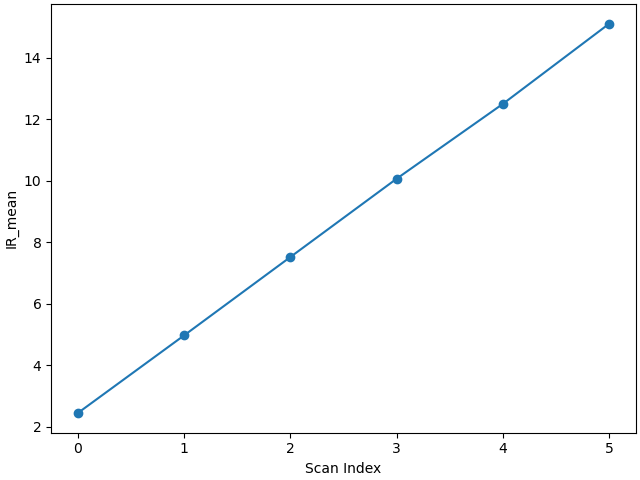

In [25]:
# Plot different variables over scan index
scan_axis = "IR_mean"

fig, ax = plt.subplots()
ax.plot(data[scan_axis].values, "-o")
ax.set_xlabel("Scan Index")
ax.set_ylabel(scan_axis)

interactive(children=(FloatRangeSlider(value=(-5.948429923727061, 33.15857250093654), description='contrast', …

interactive(children=(IntSlider(value=0, description='nr', max=5), Output()), _dom_classes=('widget-interact',…

Text(0.5, 1.0, 'Images of scan')

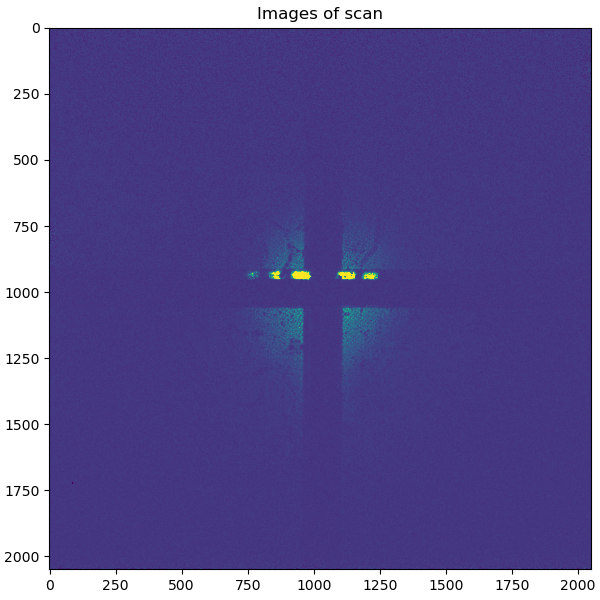

In [26]:
# Plot images
fig, ax = cimshow(images)
fig.set_size_inches(6, 6)
ax.set_title("Images of scan")

# Preprocessing

## Draw beamstop mask

interactive(children=(FloatRangeSlider(value=(-1.9374641688874583, 10.576627776307895), description='contrast'…

Click on the figure to create a polygon.
Press the 'esc' key to start a new polygon.
Try holding the 'shift' key to move all of the vertices.
Try holding the 'ctrl' key to move a single vertex.


Button(button_style='warning', description='Add mask', layout=Layout(height='auto', width='100px'), style=Butt…

Button(description='Delete mask', layout=Layout(height='auto', width='100px'), style=ButtonStyle())

Output()

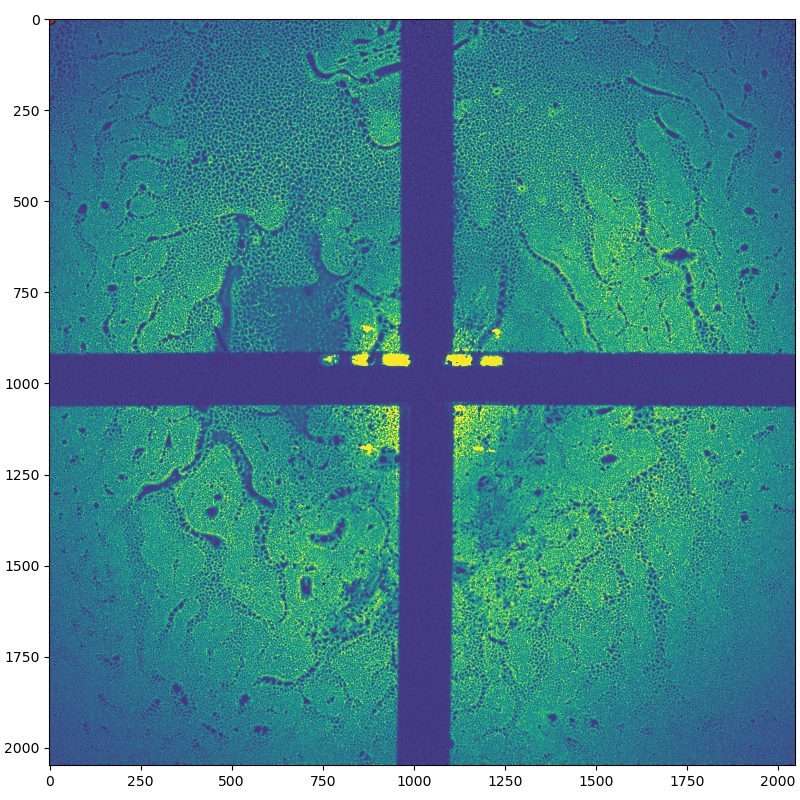

In [27]:
poly_mask = interactive.draw_polygon_mask(im_mean)

interactive(children=(FloatRangeSlider(value=(0.0, 0.0), description='contrast', layout=Layout(width='500px'),…

Mask coordinates: []


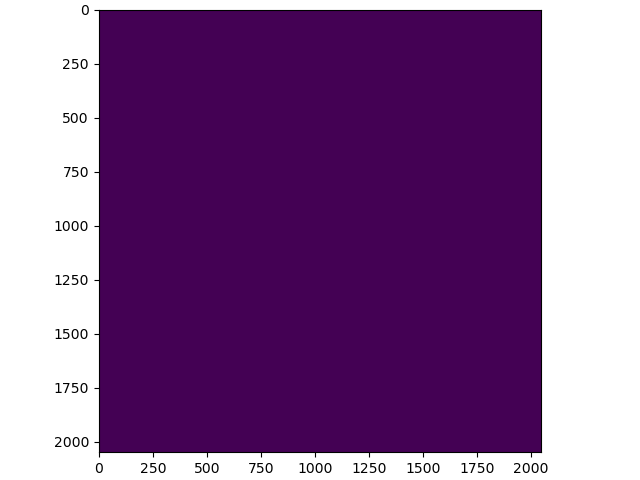

In [28]:
# Take poly coordinates and mask from widget
p_coord = poly_mask.coordinates
mask = poly_mask.full_mask.astype(int)

cimshow(mask)

print("Mask coordinates: %s" % p_coord)

In [29]:
def load_poly_coordinates(polyname):
    if polyname == "bs_cross":
        coord = [
            (946.9258289571189, 901.9078818510652),
            (-13.52166457167948, 915.628560330048),
            (-8.033393180086364, 1107.7180590358075),
            (944.1816932613224, 1099.4856519484179),
            (946.9258289571189, 1988.5856173865054),
            (945.4332858438797, 2042.780748713184),
            (1134.4167167610876, 2056.6765892218023),
            (1145.5333891679823, 1092.305257923697),
            (2007.0755007023129, 1106.2010984323151),
            (2067.2340362524137, 1100.0546685633194),
            (2067.2340362524137, 910.7093055533562),
            (1147.9485781605636, 902.4768984659665),
            (1153.4368495521567, -38.761645192255855),
            (955.8590794548038, -22.296831017476507),
        ]

    return coord

C:\Users\klose\AppData\Local\Temp\ipykernel_20408\1292557479.py:11: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


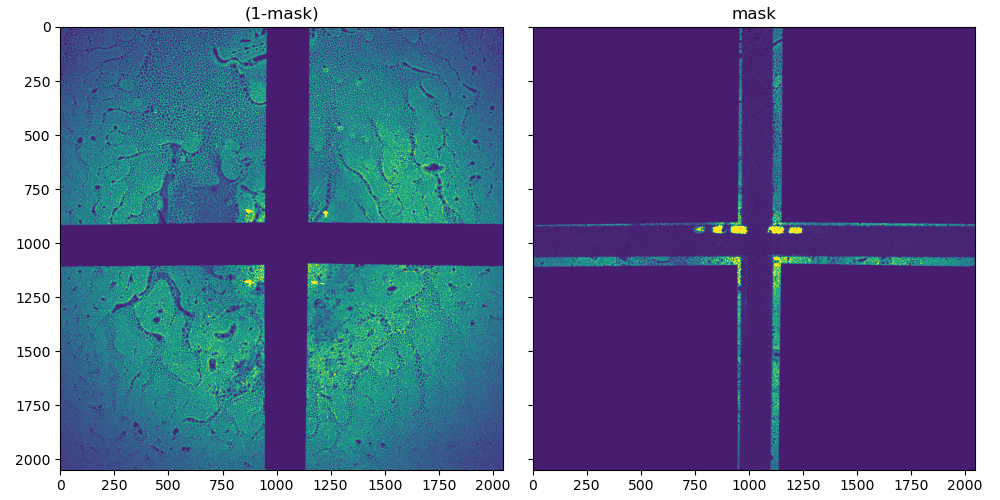

In [30]:
# Which drawn masks do you want to load?
polygon_names = ["bs_cross"]
mask = load_poly_masks(polygon_names, images[0].shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
mi, ma = np.percentile(im_mean, [1, 99])
ax[0].imshow(im_mean * (1 - mask), vmin=mi, vmax=ma)
ax[0].set_title("(1-mask)")
ax[1].imshow(im_mean * mask, vmin=mi, vmax=ma)
ax[1].set_title("mask")
plt.tight_layout()

## Find center

### Basic widget to find center

Try to **align** the circles to the **center of the scattering pattern**. Care! Position of beamstop might be misleading and not represent the actual center of the hologram. 

interactive(children=(FloatRangeSlider(value=(-5.4097474029147685, 31.538140160635564), description='contrast'…

interactive(children=(IntText(value=1024, description='c0', step=0), IntText(value=1024, description='c1', ste…

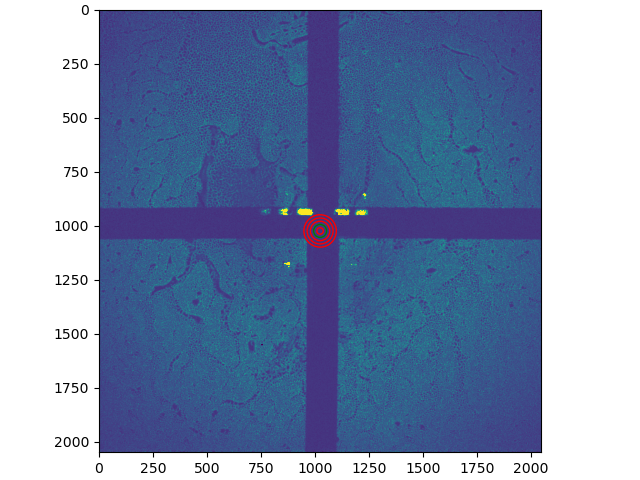

In [32]:
# Set center position via widget
ic = interactive.InteractiveCenter(images[4])

In [33]:
# Get center positions
center = [ic.c0, ic.c1]
print(f"Center:", center)

Center: [1024, 1033]


### Azimuthal integrator widget for finetuning

In [34]:
# Setup azimuthal integrator for virtual geometry
ai = interactive.AzimuthalIntegrator(
    dist=experimental_setup["ccd_dist"],
    detector=detector,
    wavelength=experimental_setup["lambda"],
    poni1=center[0]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # y (vertical)
    poni2=center[1]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # x (horizontal)
)

Text(0.5, 1.0, 'Azimuthal integration')

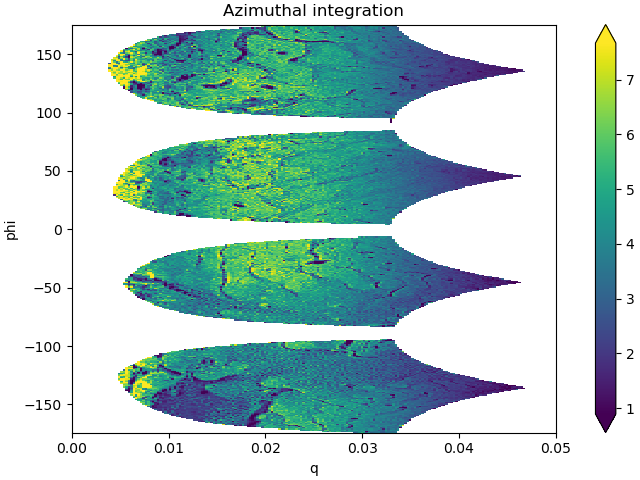

In [35]:
# Plotting to find  relevant q range
I_t, q_t, phi_t = ai.integrate2d(
    im_mean,
    200,
    radial_range=(0, 0.05),
    unit="q_nm^-1",
    correctSolidAngle=False,
    dummy=np.nan,
    mask=mask,
)
az2d = xr.DataArray(I_t, dims=("phi", "q"), coords={"q": q_t, "phi": phi_t})

# Plot
fig, ax = plt.subplots()
mi, ma = np.nanpercentile(I_t, [1, 99])
az2d.plot.imshow(ax=ax, vmin=mi, vmax=ma)
plt.title(f"Azimuthal integration")

# Vertical lines
# q_lines = [0.025, 0.05]
# for qt in q_lines:
#    ax.axvline(qt, ymin=0, ymax=180, c="red")

interactive(children=(FloatSlider(value=1024.0, description='y-center', layout=Layout(width='500px'), max=1365…

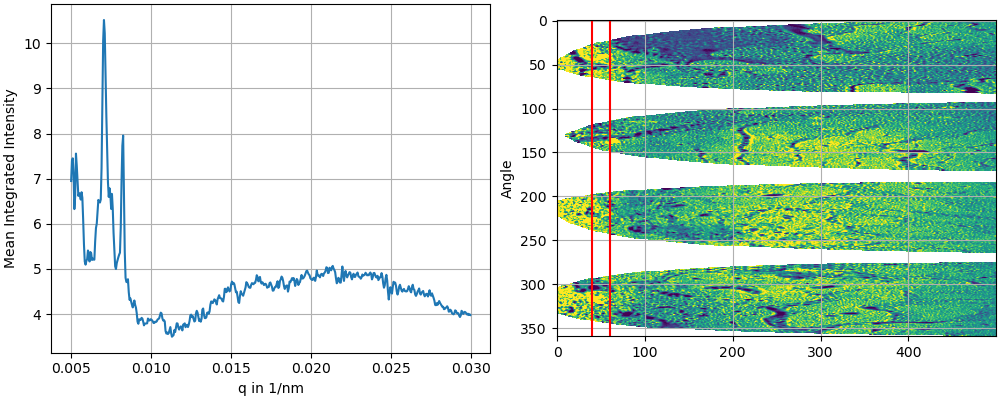

In [36]:
aic = interactive.AzimuthalIntegrationCenter(
    # np.log10(images[36] - np.min(images[36]) + 1),
    im_mean,
    ai,
    c0=center[0],
    c1=center[1],
    mask=mask,
    im_data_range=[1, 95],
    radial_range=(0.005, 0.03),
    qlines=[40, 60],
)

In [42]:
# Get center positions
center = [aic.c0, aic.c1]
print(f"Center:", center)

Center: [1009.0, 1034.0]


# Azimuthal Integration

In [48]:
# Setup final azimuthal integrator for virtual geometry
ai = interactive.AzimuthalIntegrator(
    dist=experimental_setup["ccd_dist"],
    detector=detector,
    wavelength=experimental_setup["lambda"],
    poni1=center[0]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # y (vertical)
    poni2=center[1]
    * experimental_setup["px_size"]
    * experimental_setup["binning"],  # x (horizontal)
)

In [49]:
# Do 2d Azimuthal integration of all images and add to xarray
list_i2d = []
for im in tqdm(images):
    i2d, q, chi = ai.integrate2d(im, 500, 90, dummy=np.nan, mask=mask)
    list_i2d.append(i2d)

# Add to xarray
data["q"] = q
data["chi"] = chi
data["i2d"] = xr.DataArray(list_i2d, dims=["scanid", "chi", "q"])
data = data.assign_attrs({"center": center})

  0%|          | 0/6 [00:00<?, ?it/s]

## Select relevant chi-range

Text(0.5, 0, 'q')

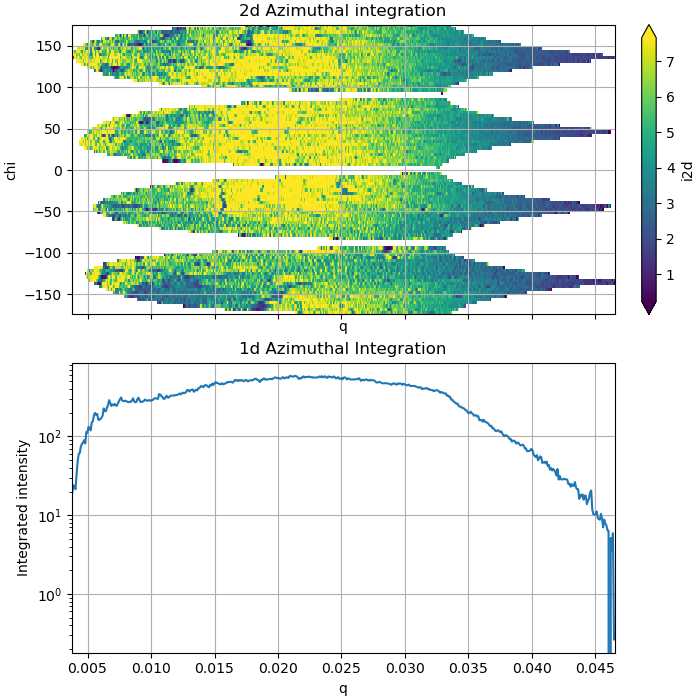

In [50]:
# Plot 2d and 1d azimuthal integration to estimate the relevant chi and q range
# which image to show?
idx = 3

# Select chi-range
# sel = (data.chi > -40) * (data.chi < 125) + (data.chi < -76) * (data.chi > 100)
# data["i1d"] = data.i2d.where(sel, drop=True).mean("chi")
data["i1d"] = data.i2d.sum("chi")

# Plot
fig, ax = plt.subplots(
    2,
    1,
    figsize=(7, 7),
    sharex=True,
)
mi, ma = np.nanpercentile(I_t, [0.1, 99])
data["i2d"][idx].plot.imshow(ax=ax[0], vmin=mi, vmax=ma)
ax[0].set_title(f"2d Azimuthal integration")
ax[0].grid()

# Plot 1d azimuthal integration to estimate the relevant q-range
ax[1].plot(data.q, data.i1d[idx])
ax[1].set_yscale("log")
ax[1].set_title("1d Azimuthal Integration")
ax[1].grid()
ax[1].set_ylabel("Integrated intensity")
ax[1].set_xlabel("q")

## Select relevant q-range and execute

In [51]:
# Select relevant q-range for averaging
q0, q1 = 0.005, 0.04
binning = False
bins = []

# Get SAXS from q-range
sel = (data.q > q0) * (data.q < q1)
data["saxs"] = data.i1d.where(sel, drop=True).sum("q")

# Averaging of same scan axis values or binning
if binning is True:
    # Execute binning
    data_bin = data.groupby_bins(scan_axis, bins).mean()

    # Rename binned values, drop intervals as those cannot be save in h5
    bin_scan_axis = scan_axis + "_bins"
    data_bin = data_bin.swap_dims({bin_scan_axis: scan_axis})
    data_bin = data_bin.drop(bin_scan_axis)
else:
    _, count = np.unique(data[scan_axis].values, return_counts=True)
    if np.any(count > 1):
        data_bin = data.groupby(scan_axis).mean()
    else:
        data_bin = data.copy()

# Add AI mask
data_bin["mask"] = xr.DataArray(mask, dims=["y", "x"])

## Plotting

### 1d AI & SAXS

Saving: C:\Users\klose\MBI - Klose\Projects\FERMI_22_05\Analysis\Post-Beamtime-Analysis\S2205ref\H2\ID_033-039\SAXS_H2_HystScan_Inverted_039_klose.png


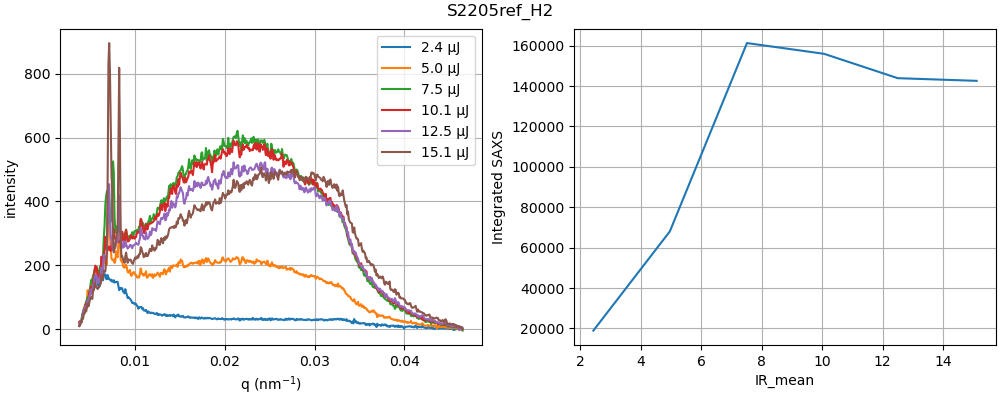

In [52]:
# Plot all 1d AI
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle(sample + "_" + membrane)
for i in range(len(data_bin["scanid"])):
    ax[0].plot(
        data_bin.q, data_bin["i1d"][i].values, label="%0.1f µJ" % data_bin["IR_mean"][i]
    )
ax[0].legend()
ax[0].set_xlabel("q (nm$^{-1}$)")
ax[0].set_ylabel("intensity")
ax[0].grid()

# Plot Integrated SAXS
ax[1].plot(
    data_bin[scan_axis].values, data_bin["saxs"].values, label="Azimuthal Integration"
ax[1].set_xlabel(scan_axis)
ax[1].set_ylabel("Integrated SAXS")
ax[1].grid()

# Save fig
fname = join(fsave, "Fluence_%s_%s.png" % (scan, USER))
print("Saving: %s" % fname)
plt.savefig(fname)

### GIF

Select roi for plotting

How to use:
1. Zoom into the image and adjust your FOV until you are satisfied.
2. Save the axes coordinates.

interactive(children=(FloatRangeSlider(value=(-5.948429923727061, 33.15857250093654), description='contrast', …

interactive(children=(IntSlider(value=0, description='nr', max=5), Output()), _dom_classes=('widget-interact',…

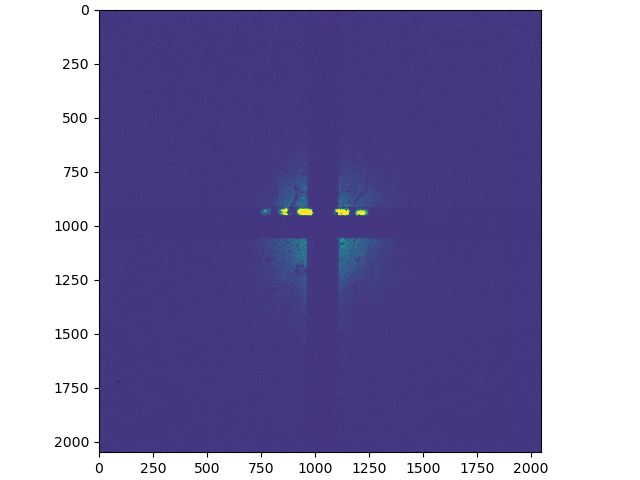

In [42]:
fig, ax = cimshow(data_bin["images"].values)

In [43]:
# Takes start and end of x and y axis
x1, x2 = ax.get_xlim()
y2, y1 = ax.get_ylim()
roi = np.array([int(y1), int(y2), int(x1), int(x2)])
roi_s = np.s_[roi[0] : roi[1], roi[2] : roi[3]]
print(f"Roi:", roi)

Roi: [   0 2047    0 2047]


## Plotting

In [53]:
# Find max and min considering all images
allmin, allmax = np.nanpercentile(data_bin["i2d"].values, [3, 97])
print("Min: %d Max: %d" % (allmin, allmax))

# Create folder for gif single frames
folder_gif = create_folder(join(fsave, "Scan_%s-%s" % (scans[0], scans[-1])))

im_fnames = []
for i in tqdm(range(len(data_bin[scan_axis].values))):
    # Plot for averaged image
    fig = plt.figure(figsize=(6.5, 10))
    gs1 = gridspec.GridSpec(
        2,
        1,
        figure=fig,
        left=0.2,
        bottom=0.05,
        right=0.975,
        top=1.1,
        wspace=0,
        hspace=0,
        height_ratios=[3, 1],
    )

    ax0 = fig.add_subplot(gs1[0])
    tmp = data_bin["images"][i].values
    m = ax0.imshow(tmp[roi_s], vmin=allmin, vmax=allmax)
    ax0.set_title(
        f"%s:  %s = %.2f"
        % (data_bin["scan"][i].values, scan_axis, data_bin[scan_axis].values[i])
    )
    plt.colorbar(m, ax=ax0, pad=0.045, location="bottom")

    ax1 = fig.add_subplot(gs1[1])
    ax1.plot(data_bin[scan_axis].values, data_bin["saxs"].values)
    ax1.scatter(
        data_bin[scan_axis].values[i], data_bin["saxs"].values[i], 20, color="r"
    )
    ax1.set_xlabel(scan_axis)
    ax1.set_ylabel("Integrated intensity")
    ax1.grid()

    # Save
    fname = join(folder_gif, "Fluence_%s-%s_%02d_%s.png" % (scans[0], scans[-1], i, USER))
    im_fnames.append(fname)
    plt.savefig(fname)
    plt.close()

# Create gif for 1d AI
var = [imageio.imread(file) for file in im_fnames]
fname = f"Fluence_%s-%s_%s.gif" % (scans[0], scans[-1], USER)
gif_path = join(fsave, fname)
print("Saving gif:%s" % gif_path)
imageio.mimsave(gif_path, var, fps=2)
print("Done!")

Min: 0 Max: 8


  0%|          | 0/6 [00:00<?, ?it/s]

Saving gif:C:\Users\klose\MBI - Klose\Projects\FERMI_22_05\Analysis\Post-Beamtime-Analysis\S2205ref\H2\ID_033-039\SAXS_H2_HystScan_Inverted_033-H2_HystScan_Inverted_039_klose.gif
Done!


In [45]:
# Drop images
data_bin = data_bin.drop_vars(["images"])

# Save log
folder = join(fsave, "Logs")
create_folder(folder)
fname = join(folder, "Log_SAXS_Scan_%s-%s_%s.nc" % (scans[0], scans[-1], USER))

print(f"Saving:", fname)
data_bin.to_netcdf(fname)

Creating folder C:\Users\klose\MBI - Klose\Projects\FERMI_22_05\Analysis\Post-Beamtime-Analysis\S2205ref\H2\ID_033-039\Logs
Saving: C:\Users\klose\MBI - Klose\Projects\FERMI_22_05\Analysis\Post-Beamtime-Analysis\S2205ref\H2\ID_033-039\Logs\Log_SAXS_Scan_H2_HystScan_Inverted_033-H2_HystScan_Inverted_039_klose.nc
